In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

### Task 1: Load the Data* and Make Transformations

*Data Source: U.S. Census Bureau and U.S. Department of Housing and Urban Development, New One Family Houses Sold: United States HSN1F, 
retrieved from FRED, Federal Reserve Bank of St. Louis; 
https://fred.stlouisfed.org/series/HSN1F, March 3

In [49]:
housesales=pd.read_csv('new_one_family_houses.csv')
housesales
scaler=MinMaxScaler()
scaler.fit(housesales.Sales.values.reshape(-1,1))
housesalesscaled=scaler.transform(housesales.Sales.values.reshape(-1,1))
housesales['housesalesscaled']=housesalesscaled
housesales=housesales.rename(columns={'Unnamed: 0':'Date'})
housesales

,Date,Sales,housesalesscaled
0,1963-01-01,591.0,0.286863
1,1963-02-01,464.0,0.173369
2,1963-03-01,461.0,0.170688
3,1963-04-01,605.0,0.299374
4,1963-05-01,586.0,0.282395
...,...,...,...
692,2020-09-01,965.0,0.621090
693,2020-10-01,965.0,0.621090
694,2020-11-01,839.0,0.508490
695,2020-12-01,885.0,0.549598


### Task 2: Descriptive Statistics and Visualizations of the Data.

In [4]:
housesales.describe()

,Sales,housesalesscaled
count,697.000000,697.000000
mean,654.005739,0.343169
std,211.685830,0.189174
min,270.000000,0.000000
25%,510.000000,0.214477
50%,625.000000,0.317248
75%,767.000000,0.444147
max,1389.000000,1.000000


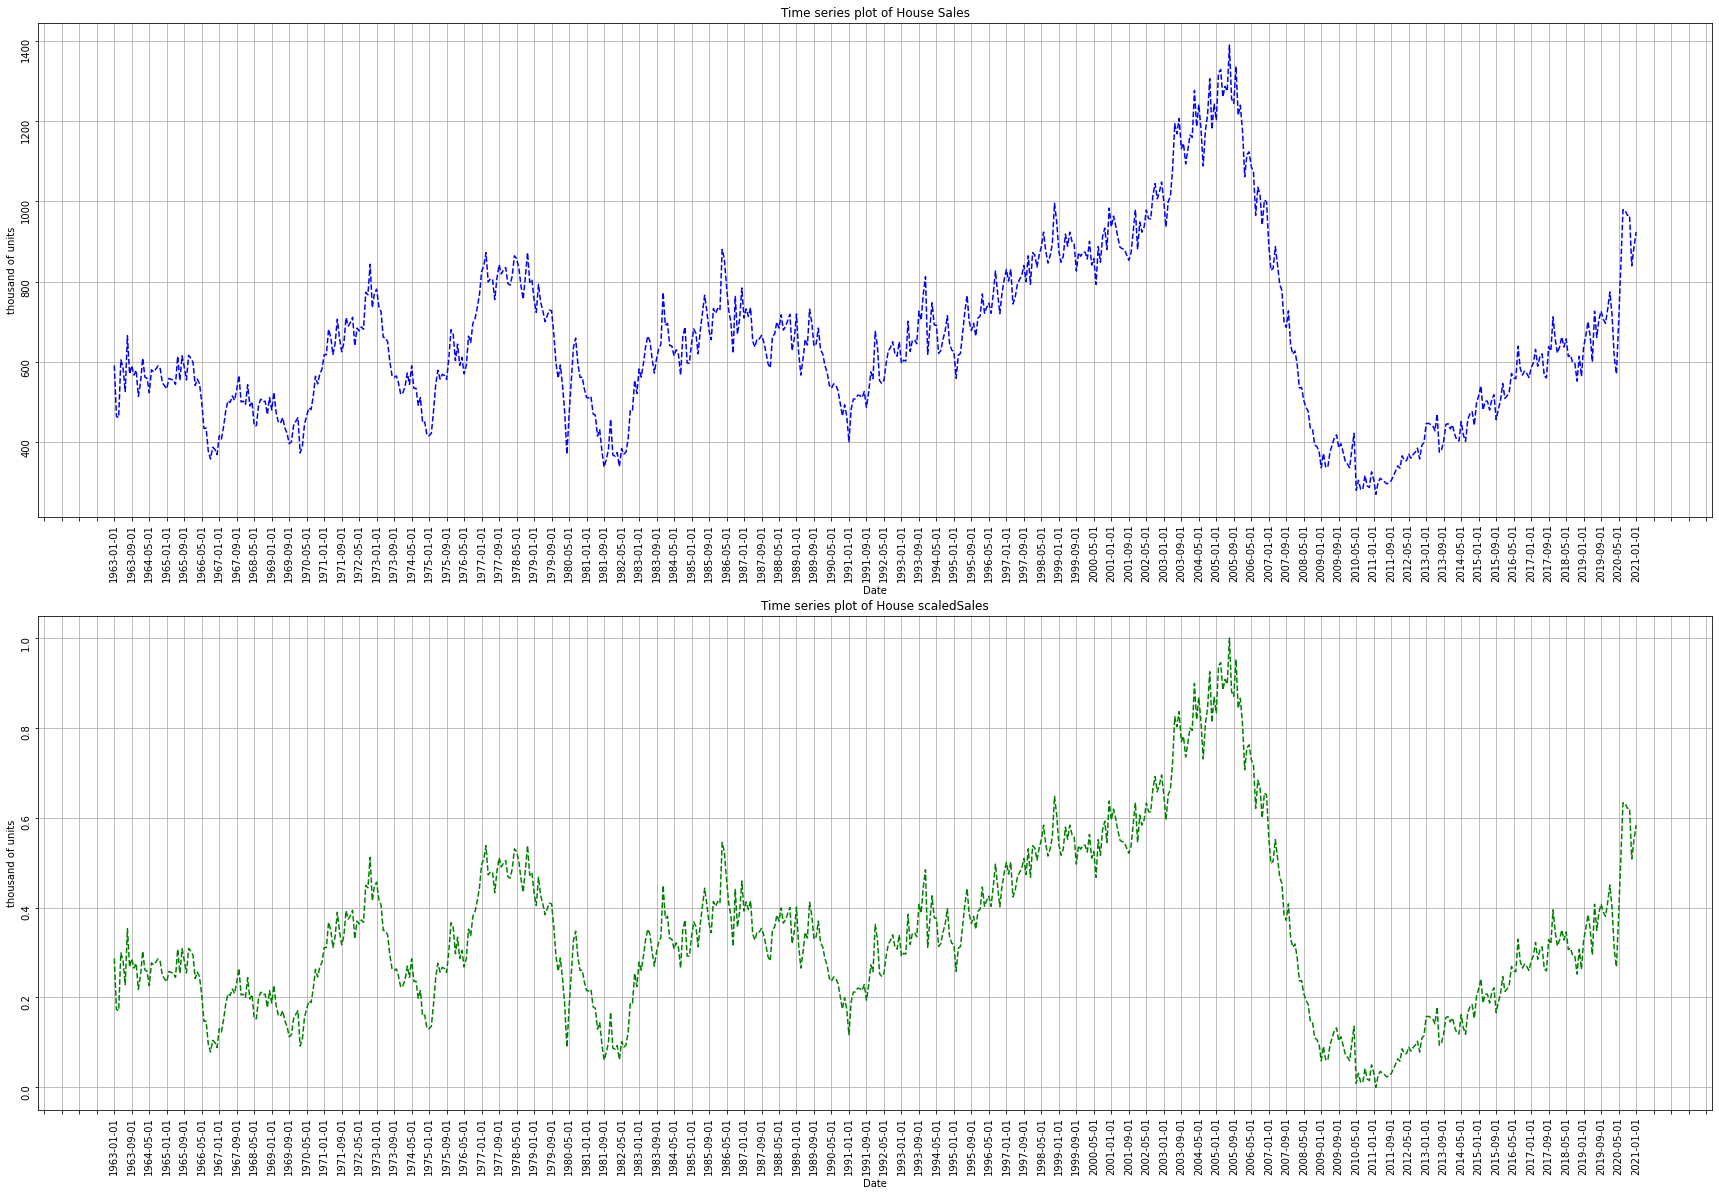

In [5]:
fig=plt.figure()
gs=GridSpec(2,1,figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M=100
xticks=ticker.MaxNLocator(M)

ax1=fig.add_subplot(gs[0,0])
ax1.plot(housesales.Date,housesales.Sales,'b--')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('thousand of units')
ax1.title.set_text('Time series plot of House Sales')
ax1.grid(True)

ax2=fig.add_subplot(gs[1,0])
ax2.plot(housesales.Date,housesales.housesalesscaled,'g--')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('thousand of units')
ax2.title.set_text('Time series plot of House scaledSales')
ax2.grid(True)

plt.savefig('imager1.png')
plt.show()

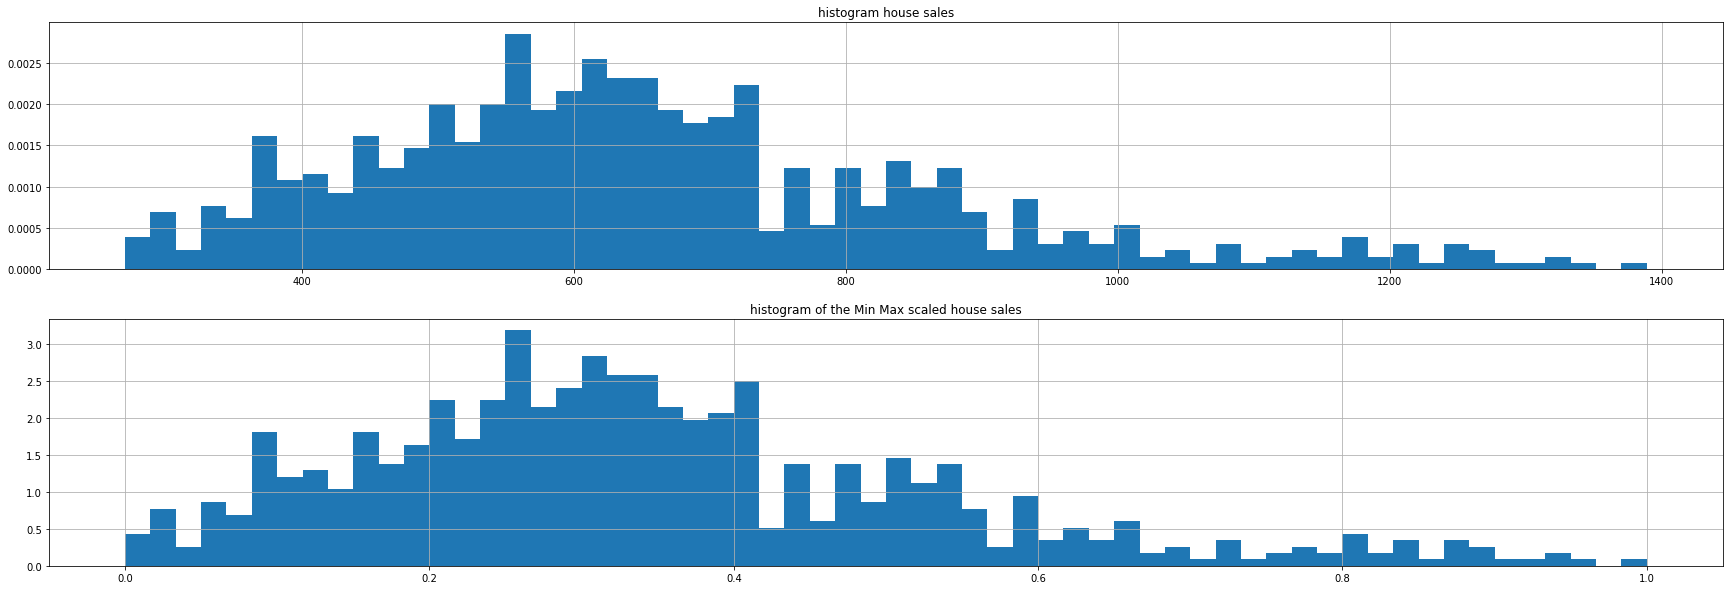

In [6]:
fig =plt.figure()
gs=GridSpec(2,1,figure=fig)

fig.set_figheight(10)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1=fig.add_subplot(gs[0,0])
ax1.hist(housesales.Sales,density=True,bins=60)
ax1.title.set_text('histogram house sales')
ax1.grid(True)

ax2=fig.add_subplot(gs[1,0])
ax2.hist(housesales.housesalesscaled,density=True,bins=60)
ax2.title.set_text('histogram of the Min Max scaled house sales')
ax2.grid(True)

plt.savefig('image2.png')
plt.show()


### Task 3: Unit Root Tests.

In [7]:
result=adfuller(housesales.Sales.values,autolag='AIC')
print(f'ADF statistics:{result[0]}')
print(f'p-value:{result[1]}')
for key,value in result[4].items():
    print('critical values:')
    print(f' {key},{value}')

ADF statistics:-2.8085520725549897
p-value:0.05706251126952963
critical values:
 1%,-3.4400605106273368
critical values:
 5%,-2.865824986587412
critical values:
 10%,-2.5690518865761


In [9]:
result=adfuller(housesales.housesalesscaled.values,autolag='AIC')
print(f'ADF statistics:{result[0]}')
print(f'p-value:{result[1]}')
for key,value in result[4].items():
    print('critical values:')
    print(f' {key},{value}')

ADF statistics:-2.808552072555019
p-value:0.057062511269525495
critical values:
 1%,-3.4400605106273368
critical values:
 5%,-2.865824986587412
critical values:
 10%,-2.5690518865761


### Task 4: Autocorrelations and Partial Autocorrelations Plots.

In [11]:
acfsalesscaled=acf(housesales.housesalesscaled,fft=True,nlags=40)
acfsalesscalednp=np.array(acfsalesscaled)

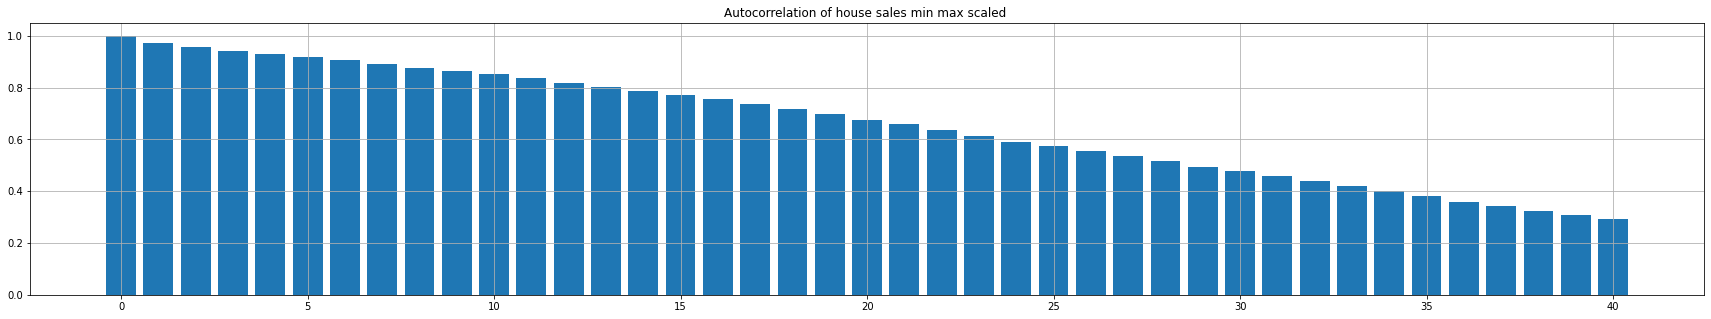

In [16]:
plt.figure(figsize=(30,5))
plt.title('Autocorrelation of house sales min max scaled ')
plt.bar(range(len(acfsalesscalednp)),acfsalesscalednp)
plt.grid(True)

plt.savefig('image3.png')
plt.show()

In [19]:
acfsalesscaled=pacf(housesales.housesalesscaled,nlags=40)
acfsalesscalednp=np.array(acfsalesscaled)

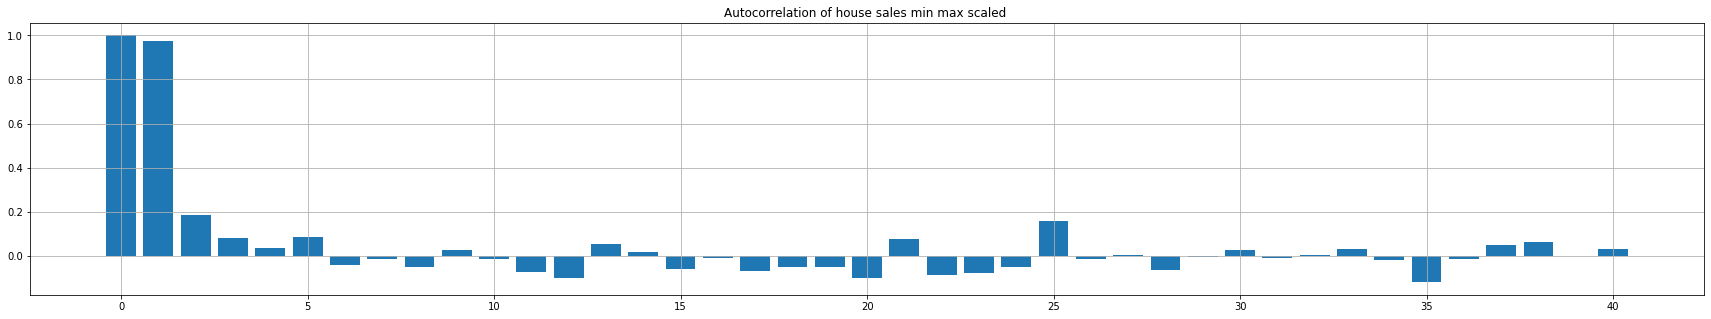

In [20]:
plt.figure(figsize=(30,5))
plt.title('Autocorrelation of house sales min max scaled ')
plt.bar(range(len(acfsalesscalednp)),acfsalesscalednp)
plt.grid(True)

plt.savefig('image4.png')
plt.show()

### Task 5: Separating into a Training and Validation Set Fomat to Use Feed into LSTM.

In [25]:
Size= len(housesales.housesalesscaled)
Window_Size=48
Batch_Size=Size-2*Window_Size
Epochs =200

In [28]:
DateTrain=housesales.Date.values[0:Batch_Size]
DateValid=housesales.Date.values[Batch_size:]
Xtrain=housesales.housesalesscaled.values[0:Batch_Size].astype('float32')
Xvalid=housesales.housesalesscaled.values[Batch_size:].astype('float32')


DataTrain=np.reshape(DateTrain,(-1,1))
Datevalid=np.reshape(DateValid,(-1,1))

In [32]:
def windowed_dataset(series,window_size=Window_Size,batch_size=Batch_Size):
    series=tf.expand_dims(series,axis=-1)
    dataset=tf.data.Dataset.from_tensor_slices(series)
    dataset=dataset.window(window_size+1,shift=1,drop_remainder=True)
    dataset=dataset.flat_map(lambda window:window.batch(window_size+1))
    dataset=dataset.map(lambda window:(window[:-1],window[-1:]))
    dataset=dataset.batch(batch_size).prefetch(1)
    return dataset
Datasettrain= windowed_dataset(Xtrain)
Datasetval=windowed_dataset(Xvalid)

Datasettrain=windowed_dataset(Xtrain)
Datasetval=windowed_dataset(Xvalid)

### Task 6: Define and Estimate the LSTM.

In [36]:
model=tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8,input_shape=[None,1],return_sequences=True),
    tf.keras.layers.LSTM(4),
    tf.keras.layers.Dense(1)

])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 8)           320       
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [38]:
optimizer=tf.keras.optimizers.Adam()
model.compile(loss='huber_loss',optimizer=optimizer)
history=model.fit(Datasettrain,epochs=Epochs,validation_data=Datasetval,verbose=1)

Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 0.0775 - val_loss: 0.0635
Epoch 2/200
1/1 [==============================] - 0s 195ms/step - loss: 0.0736 - val_loss: 0.0601
Epoch 3/200
1/1 [==============================] - 0s 178ms/step - loss: 0.0699 - val_loss: 0.0568
Epoch 4/200
1/1 [==============================] - 0s 209ms/step - loss: 0.0664 - val_loss: 0.0537
Epoch 5/200
1/1 [==============================] - 0s 205ms/step - loss: 0.0629 - val_loss: 0.0506
Epoch 6/200
1/1 [==============================] - 0s 187ms/step - loss: 0.0595 - val_loss: 0.0476
Epoch 7/200
1/1 [==============================] - 0s 199ms/step - loss: 0.0563 - val_loss: 0.0447
Epoch 8/200
1/1 [==============================] - 0s 198ms/step - loss: 0.0532 - val_loss: 0.0419
Epoch 9/200
1/1 [==============================] - 0s 194ms/step - loss: 0.0502 - val_loss: 0.0393
Epoch 10/200
1/1 [==============================] - 0s 200ms/step - loss: 0.0474 - val_loss: 0.0367
Epoch 11/200

<function matplotlib.pyplot.show(close=None, block=None)>

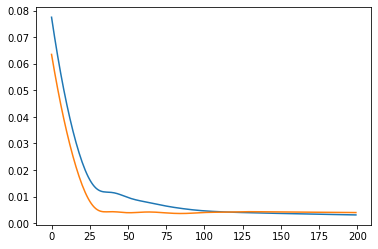

In [39]:
fig=plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show

### Task 7: Forecast the LSTM on the Validation Set and Assess Accuracy.

In [51]:
def model_forecast(model,series,window_size):
    ds=tf.data.Dataset.from_tensor_slices(series)
    ds=ds.window(window_size,shift=1,drop_remainder=True)
    ds=ds.flat_map(lambda w:w.batch(window_size))
    ds=ds.batch(Size).prefetch(1)
    forecast=model.predict(ds)
    return forecast
forecast=model_forecast(model,housesales.housesalesscaled.values[:,np.newaxis],Window_Size)
results=forecast[Batch_Size-Window_Size:-1]
results1=scaler.inverse_transform(results.reshape(-1,1))
Xvalid1=scaler.inverse_transform(Xvalid.reshape(-1,1))

In [57]:
mae=tf.keras.metrics.mean_absolute_error(Xvalid1[:,-1],results[:,-1]).numpy()
rmse=np.sqrt(tf.keras.metrics.mean_squared_error(Xvalid1[:,-1],results[:,-1]).numpy())


In [58]:
print({mae},{rmse})

{588.1643} {604.19696}
